In [ ]:
!pip install numpy pandas matplotlib seaborn tensorflow==2.15.0 scikit-learn xgboost scikeras keras-tuner

In [4]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import csv
# from google.colab import drive
import io
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from scipy.stats import uniform, randint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import ParameterSampler

In [6]:
file_path = '/Users/jacques/Desktop/solar/nrel_solar_irradiance_data_2016_2019_combined.csv'


import pandas as pd
df = pd.read_csv(file_path)

In [7]:
df

,DATE (MM/DD/YYYY),EST,Global Horizontal [W/m^2],Air Temperature [deg C],Rel Humidity [%],Avg Wind Speed @ 42ft [m/s],Peak Wind Speed @ 42ft [m/s],Avg Wind Direction @ 42ft [deg from N],Est Pressure [mBar],Precipitation [mm],Precipitation (Accumulated) [mm]
0,1/1/2016,04:00,0.0,2.811,84.5,0.463,0.95,139.50,1046,0.0,0.0
1,1/1/2016,04:01,0.0,2.849,84.5,0.425,0.95,175.50,1046,0.0,0.0
2,1/1/2016,04:02,0.0,2.879,84.6,0.225,0.50,134.80,1046,0.0,0.0
3,1/1/2016,04:03,0.0,2.939,84.5,0.800,1.55,150.10,1046,0.0,0.0
4,1/1/2016,04:04,0.0,2.955,84.4,0.825,1.55,157.10,1046,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1355756,11/19/2019,19:56,0.0,7.442,82.4,0.200,0.20,9.45,1029,0.0,0.0
1355757,11/19/2019,19:57,0.0,7.442,82.2,0.200,0.20,9.45,1029,0.0,0.0
1355758,11/19/2019,19:58,0.0,7.444,82.0,0.200,0.20,325.60,1029,0.0,0.0
1355759,11/19/2019,19:59,0.0,7.439,82.0,0.200,0.20,222.00,1029,0.0,0.0


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/nrel_solar_irradiance_data_2016_2019_combined.csv'


Mounted at /content/drive


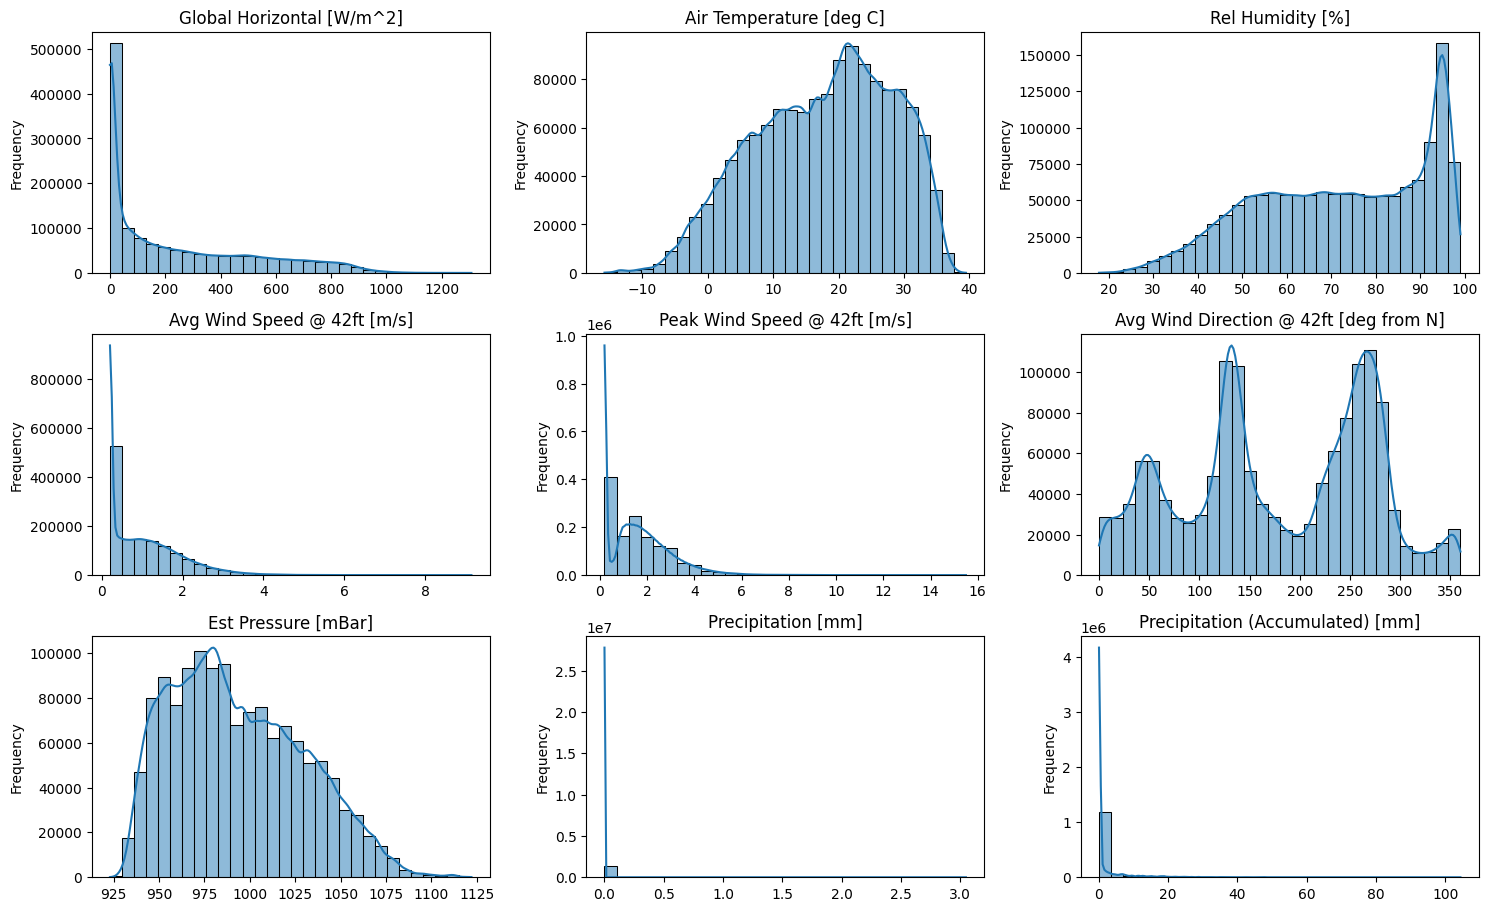

In [ ]:
# def plot_feature_histograms(df, bins=30):
#     """
#     Plots histograms for all numeric features in the dataset.
#     """
#     numeric_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns

#     plt.figure(figsize=(15, 12))  # Set figure size
#     for i, col in enumerate(numeric_cols, 1):
#         plt.subplot(len(numeric_cols) // 3 + 1, 3, i)  # Create subplots
#         sns.histplot(df[col], bins=bins, kde=True)  # Plot histogram with density curve
#         plt.title(col)  # Add title
#         plt.xlabel("")  # Remove x-labels to avoid clutter
#         plt.ylabel("Frequency")

#     plt.tight_layout()
#     plt.show()


# plot_feature_histograms(df)

In [8]:
# Convert the 'DATE (MM/DD/YYYY)' column to datetime format
df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format="%m/%d/%Y")

# Drop rows with NaN values in the 'EST' column
df.dropna(subset=['EST'], inplace=True)  # Drop rows with NaN values in 'EST'

# Extract hour and minute components from the 'EST' column and create new columns
df[['Hour', 'Minute']] = df['EST'].str.extract('(\d+):(\d+)', expand=True)

# Convert the hour and minute components to integers
df[['Hour', 'Minute']] = df[['Hour', 'Minute']].astype(int)

# Create a timedelta column using the hour and minute components
df['Timedelta'] = pd.to_timedelta(df['Hour'], unit='h') + pd.to_timedelta(df['Minute'], unit='m')

# Combine the date with the timedelta to get a complete datetime
df['Datetime'] = df['DATE (MM/DD/YYYY)'] + df['Timedelta']

# Set the Datetime column as the index
df.set_index('Datetime', inplace=True)

In [9]:
# Handle negative Global Horizontal values
negative_gh = df[df['Global Horizontal [W/m^2]'] < 0]
print(f"\nNumber of records with negative Global Horizontal: {len(negative_gh)}")

if len(negative_gh) > 0:
    print("\nNegative Global Horizontal records:")
    print(negative_gh)


    # Handle negative values
    # Option 1: Set negative values to 0
    df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = 0

    # Option 2: Interpolate negative values
    # df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = np.nan
    # df['Global Horizontal [W/m^2]'] = df['Global Horizontal [W/m^2]'].interpolate()

    print("\nAfter handling negative values:")
    print(f"Number of records with negative Global Horizontal: {len(df[df['Global Horizontal [W/m^2]'] < 0])}")


Number of records with negative Global Horizontal: 2

Negative Global Horizontal records:
                    DATE (MM/DD/YYYY)    EST  Global Horizontal [W/m^2]  \
Datetime                                                                  
2017-04-05 19:38:00        2017-04-05  19:38                  -0.012730   
2017-04-05 19:39:00        2017-04-05  19:39                  -0.376397   

                     Air Temperature [deg C]  Rel Humidity [%]  \
Datetime                                                         
2017-04-05 19:38:00                    19.56              81.3   
2017-04-05 19:39:00                    19.30              82.7   

                     Avg Wind Speed @ 42ft [m/s]  \
Datetime                                           
2017-04-05 19:38:00                        2.900   
2017-04-05 19:39:00                        2.513   

                     Peak Wind Speed @ 42ft [m/s]  \
Datetime                                            
2017-04-05 19:38:00         

In [10]:
"""Create new columns Wind_North and Wind_South from the wind direction"""

# Create new columns for binary representation of wind direction
df['Wind_North'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 315) | (df['Avg Wind Direction @ 42ft [deg from N]'] < 45)
df['Wind_South'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 135) & (df['Avg Wind Direction @ 42ft [deg from N]'] < 225)

# Convert boolean values to 0 and 1
df['Wind_North'] = df['Wind_North'].astype(int)
df['Wind_South'] = df['Wind_South'].astype(int)

#drop the original column.
df.drop('Avg Wind Direction @ 42ft [deg from N]', axis=1, inplace=True)

In [ ]:
# Box plot for Avg Wind Speed @ 42ft [m/s] before winsorization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
plt.title('Avg Wind Speed Before Winsorization')

# Box plot for Peak Wind Speed @ 42ft [m/s] before winsorization
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
plt.title('Peak Wind Speed Before Winsorization')

plt.tight_layout()
plt.show()

In [11]:
# List of features with outliers to be winsorized
features_with_outliers = ['Avg Wind Speed @ 42ft [m/s]', 'Peak Wind Speed @ 42ft [m/s]']

features_to_normalize = ['Air Temperature [deg C]', 'Rel Humidity [%]', 'Est Pressure [mBar]',
                          'Precipitation [mm]', 'Precipitation (Accumulated) [mm]']

# Apply winsorization to selected features to handle outliers by clipping extreme values.
for feature in features_with_outliers:
    df[feature] = winsorize(df[feature], limits=[0.05, 0.05])

# Apply normalization to scale all features to a similar range (between 0 and 1.)
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Standardize the mixed-feature dataset
mixed_features = features_with_outliers + features_to_normalize
scaler_standardize = StandardScaler()
df[mixed_features] = scaler_standardize.fit_transform(df[mixed_features])


In [ ]:
# Box plot for Avg Wind Speed @ 42ft [m/s] after winsorization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
plt.title('Avg Wind Speed After Winsorization')

# Box plot for Peak Wind Speed @ 42ft [m/s] after winsorization
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
plt.title('Peak Wind Speed After Winsorization')

plt.tight_layout()
plt.show()


In [12]:
def create_cyclical_features(df):
    """
    Create cyclical time features from datetime information.
    """
    # Ensure 'DATE (MM/DD/YYYY)' is in datetime format
    df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])

    # Hour features
    df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour
    df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
    df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # Day of Year features
    df['DayOfYear'] = df['DATE (MM/DD/YYYY)'].dt.dayofyear
    df['DayOfYear_Sin'] = np.sin((df['DayOfYear'] - 1) * (2 * np.pi / 365))
    df['DayOfYear_Cos'] = np.cos((df['DayOfYear'] - 1) * (2 * np.pi / 365))

    # Month features
    df['Month'] = df['DATE (MM/DD/YYYY)'].dt.month
    df['Month_Sin'] = np.sin((df['Month'] - 1) * (2 * np.pi / 12))
    df['Month_Cos'] = np.cos((df['Month'] - 1) * (2 * np.pi / 12))

    return df

In [15]:
def verify_and_fix_hour_features(df):
    # Check if Hour_Sin and Hour_Cos exist
    if 'Hour_Sin' not in df.columns or 'Hour_Cos' not in df.columns:
        print("Hour_Sin or Hour_Cos not found. Creating these features...")

        # Ensure Hour is present and is the correct type
        if 'Hour' not in df.columns:
            print("Hour column not found. Extracting hour from DATE column...")
            df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour

        # Convert Hour to float to ensure correct calculations
        df['Hour'] = df['Hour'].astype(float)

        # Create Hour_Sin and Hour_Cos
        df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))
    else:
        print("Hour_Sin and Hour_Cos found. Verifying calculations...")
        # Recalculate to ensure correctness
        df['Hour_Sin'] = np.sin(df['Hour'].astype(float) * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'].astype(float) * (2 * np.pi / 24))

    # Verify the columns exist and have correct data
    print("\nColumn info after verification/fix:")
    for col in ['Hour', 'Hour_Sin', 'Hour_Cos']:
        print(f"{col}: {df[col].dtype}, Range: [{df[col].min()}, {df[col].max()}]")

    return df

# Use the function
df = verify_and_fix_hour_features(df)



Hour_Sin or Hour_Cos not found. Creating these features...

Column info after verification/fix:
Hour: float64, Range: [4.0, 20.0]
Hour_Sin: float64, Range: [-1.0, 1.0]
Hour_Cos: float64, Range: [-1.0, 0.5000000000000001]


In [16]:
def select_features(df):
    # Features to definitely keep
    features_to_keep = [
        'Global Horizontal [W/m^2]',  # Target variable
        'Air Temperature [deg C]',
        'Peak Wind Speed @ 42ft [m/s]',
        'Avg Wind Speed @ 42ft [m/s]',
        'Est Pressure [mBar]',
        'Rel Humidity [%]',
        'Hour_Cos'
    ]

    # Features to consider keeping (we'll keep them for now, but you can experiment later)
    features_to_consider = [
        'Hour_Sin',
        'Wind_North',
        'Precipitation [mm]',
        'Precipitation (Accumulated) [mm]',

    ]

    # Combine all features we want to keep
    all_features_to_keep = features_to_keep + features_to_consider

    # Create a new dataframe with only the selected features
    df_selected = df[all_features_to_keep].copy()

    # Print information about dropped and kept features
    print("Features dropped:")
    print(set(df.columns) - set(all_features_to_keep))

    print("\nFeatures kept:")
    print(df_selected.columns.tolist())

    print(f"\nOriginal dataframe shape: {df.shape}")
    print(f"New dataframe shape: {df_selected.shape}")

    return df_selected

# Assuming your original dataframe is named 'df'
df_selected = select_features(df)

# If you want to save the new dataframe to a CSV file
# df_selected.to_csv('solar_irradiance_selected_features.csv', index=False)

Features dropped:
{'Wind_South', 'Minute', 'EST', 'DATE (MM/DD/YYYY)', 'Hour', 'Timedelta'}

Features kept:
['Global Horizontal [W/m^2]', 'Air Temperature [deg C]', 'Peak Wind Speed @ 42ft [m/s]', 'Avg Wind Speed @ 42ft [m/s]', 'Est Pressure [mBar]', 'Rel Humidity [%]', 'Hour_Cos', 'Hour_Sin', 'Wind_North', 'Precipitation [mm]', 'Precipitation (Accumulated) [mm]']

Original dataframe shape: (1355761, 17)
New dataframe shape: (1355761, 11)


In [17]:
def split_and_scale_data(df, target_column='Global Horizontal [W/m^2]'):
    """
    Split the data into train (2016-2018) and test (2019) sets,
    scale the numeric feature columns, and retain datetime information.
    """
    # Ensure the dataframe has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])
        df.set_index('DATE (MM/DD/YYYY)', inplace=True)

    # Split into features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train (2016-2018) and test (2019) sets
    X_train = X[X.index.year < 2019]
    X_test = X[X.index.year == 2019]
    y_train = y[y.index.year < 2019]
    y_test = y[y.index.year == 2019]

    # Initialize the scaler
    scaler = StandardScaler()

    # Separate numeric and non-numeric columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

    # Handle timedelta columns
    for col in numeric_cols:
        if pd.api.types.is_timedelta64_dtype(X_train[col]):
            X_train[col] = X_train[col].dt.total_seconds()
            X_test[col] = X_test[col].dt.total_seconds()

    # Fit the scaler on the numeric training data
    scaler.fit(X_train[numeric_cols])

    # Transform numeric columns
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[numeric_cols]),
                                  columns=numeric_cols, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]),
                                 columns=numeric_cols, index=X_test.index)

    # Add non-numeric columns back
    for col in non_numeric_cols:
        X_train_scaled[col] = X_train[col]
        X_test_scaled[col] = X_test[col]

    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Use the function
X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(df)

# Print column information
print("\nColumns in scaled data:")
print(X_train_scaled.columns.tolist())

# Check for any remaining issues
print("\nData types in scaled training data:")
print(X_train_scaled.dtypes)

# Verify scaling for numeric columns
numeric_cols = X_train_scaled.select_dtypes(include=[np.number]).columns
print("\nMean and standard deviation of scaled numeric features:")
print(X_train_scaled[numeric_cols].mean())
print(X_train_scaled[numeric_cols].std())

# Print information about non-numeric columns
non_numeric_cols = X_train_scaled.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns retained:")
print(non_numeric_cols.tolist())

/var/folders/jc/kmgcsdf1329f6vzf43vzlp580000gn/T/ipykernel_35841/1619886301.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].dt.total_seconds()
/var/folders/jc/kmgcsdf1329f6vzf43vzlp580000gn/T/ipykernel_35841/1619886301.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].dt.total_seconds()


Training set shape: (1053256, 16)
Test set shape: (302505, 16)

Columns in scaled data:
['Air Temperature [deg C]', 'Rel Humidity [%]', 'Avg Wind Speed @ 42ft [m/s]', 'Peak Wind Speed @ 42ft [m/s]', 'Est Pressure [mBar]', 'Precipitation [mm]', 'Precipitation (Accumulated) [mm]', 'Hour', 'Minute', 'Timedelta', 'Wind_North', 'Wind_South', 'Hour_Sin', 'Hour_Cos', 'DATE (MM/DD/YYYY)', 'EST']

Data types in scaled training data:
Air Temperature [deg C]                    float64
Rel Humidity [%]                           float64
Avg Wind Speed @ 42ft [m/s]                float64
Peak Wind Speed @ 42ft [m/s]               float64
Est Pressure [mBar]                        float64
Precipitation [mm]                         float64
Precipitation (Accumulated) [mm]           float64
Hour                                       float64
Minute                                     float64
Timedelta                                  float64
Wind_North                                 float64
Wind_South 

In [18]:
def time_to_decimal(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60.0

# Convert 'EST' to decimal hours
if 'EST' in X_train_scaled.columns:
    X_train_scaled['EST'] = X_train_scaled['EST'].apply(time_to_decimal)
    X_test_scaled['EST'] = X_test_scaled['EST'].apply(time_to_decimal)

# Convert datetime column to a numeric representation (timestamp)
if 'DATE (MM/DD/YYYY)' in X_train_scaled.columns:
    X_train_scaled['DATE (MM/DD/YYYY)'] = pd.to_datetime(X_train_scaled['DATE (MM/DD/YYYY)']).astype(int) / 10**9
    X_test_scaled['DATE (MM/DD/YYYY)'] = pd.to_datetime(X_test_scaled['DATE (MM/DD/YYYY)']).astype(int) / 10**9

# Ensure all columns are numeric
X_train_scaled = X_train_scaled.apply(pd.to_numeric, errors='coerce')
X_test_scaled = X_test_scaled.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns = X_train_scaled.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns after conversion:")
print(non_numeric_columns)

# Check for NaN values
print("\nNaN values in X_train_scaled:")
print(X_train_scaled.isna().sum())

print("\nNaN values in y_train:")
print(pd.isna(y_train).sum())

# If there are NaN values, you might want to handle them
X_train_scaled = X_train_scaled.fillna(X_train_scaled.mean())
X_test_scaled = X_test_scaled.fillna(X_test_scaled.mean())
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# Verify data types again
print("\nUpdated data types:")
print(X_train_scaled.dtypes)
print(y_train.dtype)

# Final check for NaN values
print("\nFinal check for NaN values in X_train_scaled:")
print(np.any(np.isnan(X_train_scaled)))
print("\nFinal check for NaN values in y_train:")
print(np.any(np.isnan(y_train)))

Non-numeric columns after conversion:
Index([], dtype='object')

NaN values in X_train_scaled:
Air Temperature [deg C]             0
Rel Humidity [%]                    0
Avg Wind Speed @ 42ft [m/s]         0
Peak Wind Speed @ 42ft [m/s]        0
Est Pressure [mBar]                 0
Precipitation [mm]                  0
Precipitation (Accumulated) [mm]    0
Hour                                0
Minute                              0
Timedelta                           0
Wind_North                          0
Wind_South                          0
Hour_Sin                            0
Hour_Cos                            0
DATE (MM/DD/YYYY)                   0
EST                                 0
dtype: int64

NaN values in y_train:
0

Updated data types:
Air Temperature [deg C]             float64
Rel Humidity [%]                    float64
Avg Wind Speed @ 42ft [m/s]         float64
Peak Wind Speed @ 42ft [m/s]        float64
Est Pressure [mBar]                 float64
Precipitation [mm

In [19]:
#drop avg wind speed
X_train_scaled.drop(columns=['Avg Wind Speed @ 42ft [m/s]'], inplace=True)
X_test_scaled.drop(columns=['Avg Wind Speed @ 42ft [m/s]'], inplace=True)

In [ ]:
def clean_column_names(df):
    def clean_name(name):
        # Remove brackets and their contents, replace spaces with underscores
        cleaned = re.sub(r'\[.*?\]', '', name).strip().replace(' ', '_')
        # Remove any remaining special characters
        cleaned = re.sub(r'[^a-zA-Z0-9_]', '', cleaned)
        return cleaned

    df.columns = [clean_name(col) for col in df.columns]
    return df


def prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature='both'):
    """
    Prepare data for XGBoost model, with option to select wind speed feature.

    Parameters:
    - X_train, X_test, y_train, y_test: Input data
    - wind_feature: 'avg', 'peak', or 'both' (default)
    """
    # Create copies to avoid modifying original data
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # Clean column names
    X_train_prep = clean_column_names(X_train_prep)
    X_test_prep = clean_column_names(X_test_prep)

    # Columns to drop
    columns_to_drop = ['DATE_MMDDYYYY', 'EST']

    # Add wind speed feature to drop based on selection
    if wind_feature == 'avg':
        columns_to_drop.append('Peak_Wind_Speed_42ft_ms')
    elif wind_feature == 'peak':
        columns_to_drop.append('Avg_Wind_Speed_42ft_ms')
    # If 'both', we don't add any wind speed feature to columns_to_drop

    # Drop specified columns
    X_train_prep = X_train_prep.drop(columns=[col for col in columns_to_drop if col in X_train_prep.columns])
    X_test_prep = X_test_prep.drop(columns=[col for col in columns_to_drop if col in X_test_prep.columns])

    # Ensure all remaining columns are numeric
    X_train_prep = X_train_prep.select_dtypes(include=[np.number])
    X_test_prep = X_test_prep.select_dtypes(include=[np.number])

    return X_train_prep, X_test_prep, y_train, y_test

In [ ]:
def train_and_evaluate_xgboost_fixed_params(X_train, X_test, y_train, y_test, wind_feature='peak'):
    # Prepare data
    X_train_prep, X_test_prep, y_train_prep, y_test_prep = prepare_data_for_xgboost(
        X_train, X_test, y_train, y_test, wind_feature
    )


    print("Shape of training data:", X_train_prep.shape)
    print("Shape of test data:", X_test_prep.shape)

    # Use known best parameters directly
    best_params = {
        'subsample': 1.0,
        'n_estimators': 200,
        'min_child_weight': 3,
        'max_depth': 5,
        'learning_rate': 0.1,
        'gamma': 0,
        'colsample_bytree': 1.0,
        'random_state': 42
    }

    # Create and train the model
    model = XGBRegressor(**best_params)
    print("Training XGBoost model with fixed best parameters...")
    model.fit(X_train_prep, y_train_prep)

    # Make predictions
    print("Making predictions...")
    predictions = model.predict(X_test_prep)

    # Calculate metrics
    mse = mean_squared_error(y_test_prep, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_prep, predictions)
    r2 = r2_score(y_test_prep, predictions)
    nrmse = (rmse / (y_test.max() - y_test.min()))

    print(f"\nXGBoost Model with {wind_feature} wind speed Performance:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"XBOOST - Normalized Root Mean Squared Error (NRMSE): {nrmse:.2%}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared Score: {r2:.4f}")

    # Plot feature importance
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(X_train_prep.columns[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'')
    plt.tight_layout()
    plt.show()

    return model, predictions, rmse, mae, r2

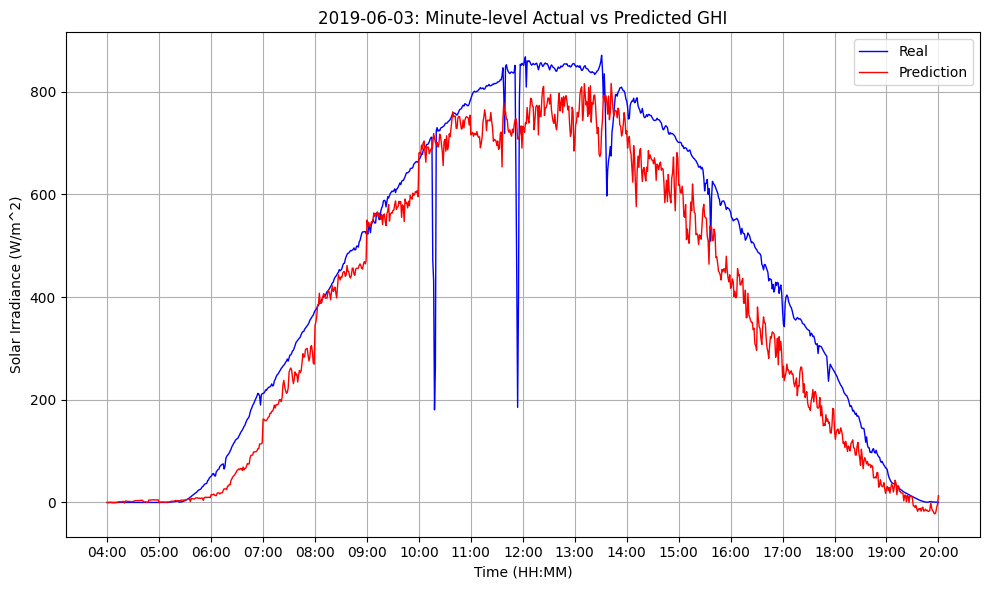

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def plot_single_day_hhmm(csv_file, date_str):
    """
    Plots Actual vs. Predicted GHI for a single day.
    The x-axis is 'minute of day' but displayed as HH:MM labels.
    """
    # 1. Read CSV and parse 'Datetime'
    df = pd.read_csv(csv_file, parse_dates=['Datetime'])

    # 2. Filter for the specified date
    df_day = df[df['Datetime'].dt.date == pd.to_datetime(date_str).date()].copy()
    if df_day.empty:
        print(f"No data found for {date_str}. Check your date or CSV content.")
        return

    # 3. Sort by time
    df_day.sort_values('Datetime', inplace=True)

    # 4. Convert each Datetime to "Minute of Day" => hour * 60 + minute
    df_day['MinuteOfDay'] = df_day['Datetime'].dt.hour * 60 + df_day['Datetime'].dt.minute

    # 5. Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        df_day['MinuteOfDay'],
        df_day['Actual_GHI'],
        label='Real',
        color='blue',
        linewidth=1
    )
    ax.plot(
        df_day['MinuteOfDay'],
        df_day['Predicted_GHI'],
        label='Prediction',
        color='red',
        linewidth=1
    )

    # Set the title, labels, and grid
    ax.set_title(f"{date_str}: Minute-level Actual vs Predicted GHI")
    ax.set_xlabel("Time (HH:MM)")
    ax.set_ylabel("Solar Irradiance (W/m^2)")
    ax.grid(True)
    ax.legend()

    # 6. Format x-axis ticks to display HH:MM
    def minute_to_hhmm(x, pos=None):
        # Convert an integer minute_of_day to "HH:MM"
        h = int(x // 60)
        m = int(x % 60)
        return f"{h:02d}:{m:02d}"

    # Set major ticks every 60 minutes (you can adjust as needed)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(minute_to_hhmm))

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_single_day_hhmm('xgboost_predictions.csv', '2019-06-03')

In [22]:
df

,DATE (MM/DD/YYYY),EST,Global Horizontal [W/m^2],Air Temperature [deg C],Rel Humidity [%],Avg Wind Speed @ 42ft [m/s],Peak Wind Speed @ 42ft [m/s],Est Pressure [mBar],Precipitation [mm],Precipitation (Accumulated) [mm],Hour,Minute,Timedelta,Wind_North,Wind_South,Hour_Sin,Hour_Cos
Datetime,,,,,,,,,,,,,,,,,
2016-01-01 04:00:00,2016-01-01,04:00,0.0,-1.438477,0.656207,-0.668082,-0.515722,1.456818,-0.077304,-0.292709,4.0,0,0 days 04:00:00,0,1,0.866025,0.500000
2016-01-01 04:01:00,2016-01-01,04:01,0.0,-1.434821,0.656207,-0.716772,-0.515722,1.456818,-0.077304,-0.292709,4.0,1,0 days 04:01:00,0,1,0.866025,0.500000
2016-01-01 04:02:00,2016-01-01,04:02,0.0,-1.431934,0.661523,-0.973035,-0.900873,1.456818,-0.077304,-0.292709,4.0,2,0 days 04:02:00,0,0,0.866025,0.500000
2016-01-01 04:03:00,2016-01-01,04:03,0.0,-1.426161,0.656207,-0.236279,-0.002188,1.456818,-0.077304,-0.292709,4.0,3,0 days 04:03:00,0,1,0.866025,0.500000
2016-01-01 04:04:00,2016-01-01,04:04,0.0,-1.424621,0.650891,-0.204246,-0.002188,1.456818,-0.077304,-0.292709,4.0,4,0 days 04:04:00,0,1,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-19 19:56:00,2019-11-19,19:56,0.0,-0.992887,0.544567,-1.005068,-1.157641,0.984479,-0.077304,-0.292709,19.0,56,0 days 19:56:00,1,0,-0.965926,0.258819
2019-11-19 19:57:00,2019-11-19,19:57,0.0,-0.992887,0.533935,-1.005068,-1.157641,0.984479,-0.077304,-0.292709,19.0,57,0 days 19:57:00,1,0,-0.965926,0.258819
2019-11-19 19:58:00,2019-11-19,19:58,0.0,-0.992694,0.523302,-1.005068,-1.157641,0.984479,-0.077304,-0.292709,19.0,58,0 days 19:58:00,1,0,-0.965926,0.258819
